In [1]:
! pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


# Modelo de Regresión para la Laguna de Torrevieja

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from skforecast.utils import load_forecaster

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers,callbacks
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Input

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
# warnings.filterwarnings('ignore')

## Preparación de los datos

In [3]:
folder = ""
parametro = 'temperatura'
output=parametro
inputs = [
          'fecha', 'temperatura',
          'ambiente', 'nivel'
          ]
usecols = inputs.copy()

datos = pd.read_csv(folder + "laguna_datos_horarios_rellenos" + ".csv",sep=',', usecols=usecols)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y %H:%M')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('H')
datos = datos.sort_index()

datos.info()

datos = datos.iloc[:]

#datos.head()
datos

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2023-06-17 00:00:00 to 2023-09-13 00:00:00
Freq: H
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2113 non-null   float64
 1   ambiente     2113 non-null   float64
 2   nivel        2113 non-null   float64
dtypes: float64(3)
memory usage: 66.0 KB


,temperatura,ambiente,nivel
fecha,,,
2023-06-17 00:00:00,31.5000,22.000000,51.0
2023-06-17 01:00:00,31.4700,21.780000,51.0
2023-06-17 02:00:00,31.2350,21.201000,47.8
2023-06-17 03:00:00,31.2950,22.439250,52.0
2023-06-17 04:00:00,31.3750,23.058375,50.0
...,...,...,...
2023-09-12 20:00:00,31.5375,25.820000,34.0
2023-09-12 21:00:00,31.4325,25.310000,36.0
2023-09-12 22:00:00,31.3350,23.930000,35.0


Limpieza de datos anómalos

In [4]:
datos = datos.iloc[:]
datos_originales = datos.copy()


datos.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2023-06-17 00:00:00 to 2023-09-13 00:00:00
Freq: H
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2113 non-null   float64
 1   ambiente     2113 non-null   float64
 2   nivel        2113 non-null   float64
dtypes: float64(3)
memory usage: 66.0 KB


## Predecir T

In [5]:
datos["t-1"] = datos["temperatura"].shift(1)
# datos["ta-12"] = datos["ambiente"].shift(12)
# datos["ta-24"] = datos["ambiente"].shift(24)
# datos["ta-36"] = datos["ambiente"].shift(36)
# datos["ta-48"] = datos["ambiente"].shift(48)

datos = datos.dropna()

datos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2112 entries, 2023-06-17 01:00:00 to 2023-09-13 00:00:00
Freq: H
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2112 non-null   float64
 1   ambiente     2112 non-null   float64
 2   nivel        2112 non-null   float64
 3   t-1          2112 non-null   float64
dtypes: float64(4)
memory usage: 82.5 KB


## Preparar los datos de train y test

In [6]:
entreno = 420 # LA SUMA ES PARA MOVERME EN LA FRANJA HORARIA DEL MISMO DÍA (ASCENDENTE O DESCENDENTE)
cola = 420 #SIEMPRE HACERLO DINÁMICO, QUE PODAMOS PASARLO POR EJEMPLO COMO ARGUMENTO

datos_dif = datos.iloc[:] #JUGAR CON LOS VALORES DE "X:Y" PARA MARCAR LA SERIE TEMPORAL QUE SE QUIERE
#datos_dif["temperatura"] = datos_dif["temperatura"].diff().dropna()
#datos_dif["t-1"] = datos_dif["t-1"].diff().dropna()
datos_dif = datos_dif.dropna()
datos_pred = datos_dif.iloc[:-entreno] # PARA TENER UNA COPIA DEL ORIGINAL Y MODIFICAR LA COPIA
predicciones = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

datos_dif.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2112 entries, 2023-06-17 01:00:00 to 2023-09-13 00:00:00
Freq: H
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2112 non-null   float64
 1   ambiente     2112 non-null   float64
 2   nivel        2112 non-null   float64
 3   t-1          2112 non-null   float64
dtypes: float64(4)
memory usage: 82.5 KB


In [7]:
datos_pred.info()
datos_pred

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2023-06-17 01:00:00 to 2023-08-26 12:00:00
Freq: H
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  1692 non-null   float64
 1   ambiente     1692 non-null   float64
 2   nivel        1692 non-null   float64
 3   t-1          1692 non-null   float64
dtypes: float64(4)
memory usage: 66.1 KB


,temperatura,ambiente,nivel,t-1
fecha,,,,
2023-06-17 01:00:00,31.4700,21.780000,51.0,31.5000
2023-06-17 02:00:00,31.2350,21.201000,47.8,31.4700
2023-06-17 03:00:00,31.2950,22.439250,52.0,31.2350
2023-06-17 04:00:00,31.3750,23.058375,50.0,31.2950
2023-06-17 05:00:00,31.3150,23.677500,48.0,31.3750
...,...,...,...,...
2023-08-26 08:00:00,32.1025,25.390000,38.0,32.2225
2023-08-26 09:00:00,32.1800,27.080000,37.0,32.1025
2023-08-26 10:00:00,32.3675,28.720000,37.0,32.1800


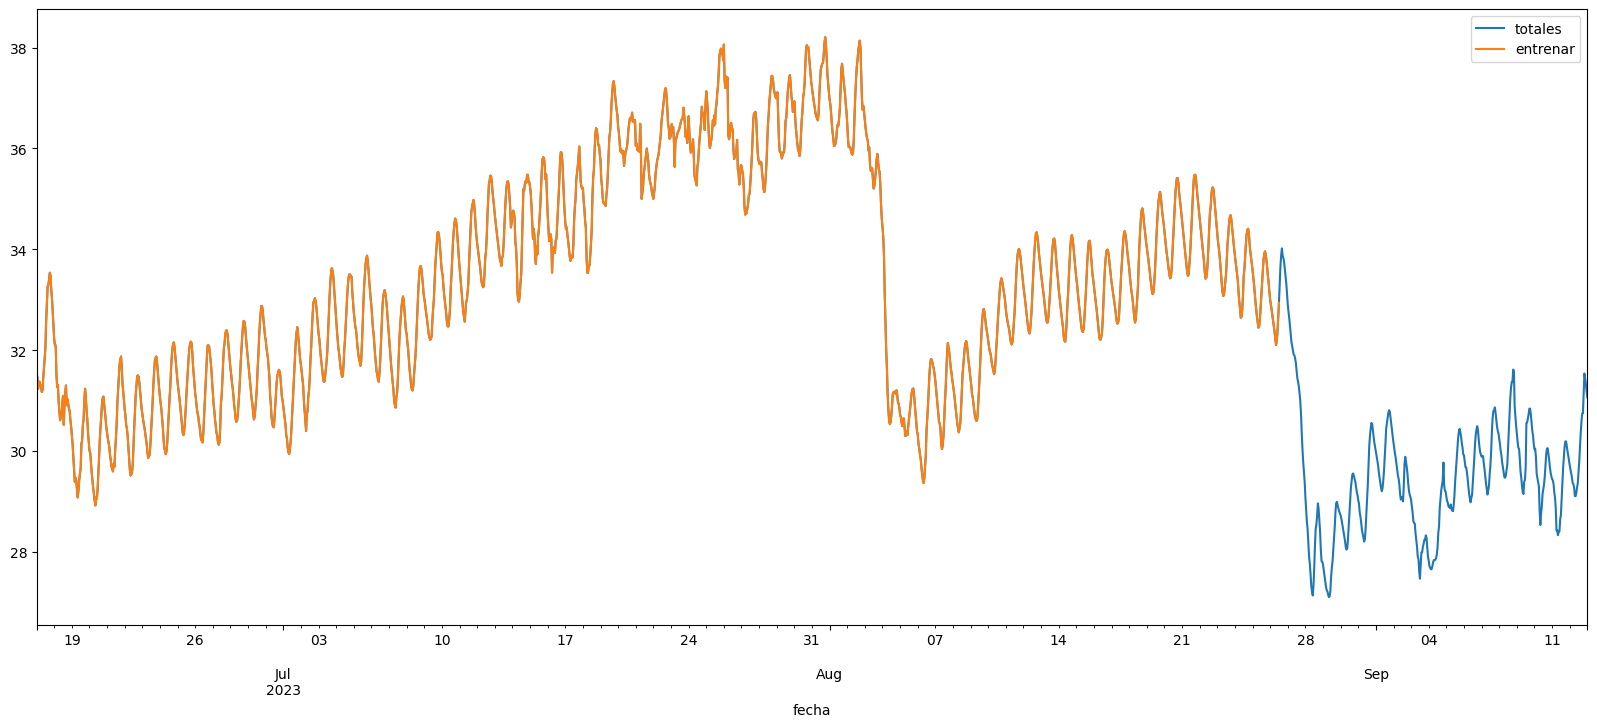

In [8]:
fig, ax = plt.subplots(figsize=(20, 8))
datos_dif['temperatura'].plot(ax=ax, label='totales')
datos_pred['temperatura'].plot(ax=ax, label='entrenar')
ax.legend();

In [9]:
from tensorflow.keras.optimizers import Adam
df = datos_dif.copy()

num_features = df.shape[1]

# interpolate missing values
df = df.interpolate(method='linear', axis=0)

# remove all nan values
df = df.dropna()

# Get the minimum and maximum values of 'eto'
min_et = df['temperatura'].min()
max_et = df['temperatura'].max()

df

,temperatura,ambiente,nivel,t-1
fecha,,,,
2023-06-17 01:00:00,31.4700,21.780000,51.0,31.5000
2023-06-17 02:00:00,31.2350,21.201000,47.8,31.4700
2023-06-17 03:00:00,31.2950,22.439250,52.0,31.2350
2023-06-17 04:00:00,31.3750,23.058375,50.0,31.2950
2023-06-17 05:00:00,31.3150,23.677500,48.0,31.3750
...,...,...,...,...
2023-09-12 20:00:00,31.5375,25.820000,34.0,31.1600
2023-09-12 21:00:00,31.4325,25.310000,36.0,31.5375
2023-09-12 22:00:00,31.3350,23.930000,35.0,31.4325


In [22]:
df

,temperatura,ambiente,nivel,t-1
fecha,,,,
2023-06-17 01:00:00,31.4700,21.780000,51.0,31.5000
2023-06-17 02:00:00,31.2350,21.201000,47.8,31.4700
2023-06-17 03:00:00,31.2950,22.439250,52.0,31.2350
2023-06-17 04:00:00,31.3750,23.058375,50.0,31.2950
2023-06-17 05:00:00,31.3150,23.677500,48.0,31.3750
...,...,...,...,...
2023-09-12 20:00:00,31.5375,25.820000,34.0,31.1600
2023-09-12 21:00:00,31.4325,25.310000,36.0,31.5375
2023-09-12 22:00:00,31.3350,23.930000,35.0,31.4325


In [10]:
# Normalize data
scaled_data = df[df.columns].values

scalers = {}
for column in df.columns:
    scalers[column] = MinMaxScaler(feature_range=(0, 1))
    scaled_data[:, df.columns.get_loc(column)] = scalers[column].fit_transform(scaled_data[:, df.columns.get_loc(column)].reshape(-1, 1)).flatten()

# Prepare input and output sequences
n_days = entreno  # Number of days in each sequence
X = []
y = []
for i in range(n_days, len(df) - n_days + 1):
    X.append(scaled_data[i-n_days:i])
    y.append(scaled_data[i:i+n_days, df.columns.get_loc('temperatura')])  # Output sequence with 7 days of Evapotranspiration


X = np.array(X)
y = np.array(y)

scaled_data

array([[0.39329131, 0.14772727, 0.84615385, 0.3959928 ],
       [0.37212967, 0.11117424, 0.72307692, 0.39329131],
       [0.37753264, 0.18934659, 0.88461538, 0.37212967],
       ...,
       [0.38113462, 0.2834596 , 0.23076923, 0.38991445],
       [0.36695182, 0.26893939, 0.23076923, 0.38113462],
       [0.35659613, 0.29166667, 0.23076923, 0.36695182]])

1/1 [==============================] - 0s 27ms/step - loss: 0.0213
Fold 1 - Test Loss: 0.021276138722896576
1/1 [==============================] - 0s 369ms/step
[[0.32142952 0.35352522 0.40486073 0.33875406 0.36974245 0.37230045
  0.36544627 0.37149474 0.39200914 0.37445527 0.3371548  0.31043082
  0.3956048  0.40026662 0.34531784 0.35117579 0.3506933  0.3643653
  0.3493696  0.36328816 0.36471185 0.3403581  0.39348269 0.3325532
  0.3687316  0.37338758 0.39006734 0.39510337 0.348187   0.37766007
  0.36218226 0.38175142 0.3848291  0.36379936 0.37943578 0.37062648
  0.34170428 0.3212205  0.3605928  0.3761096  0.33884022 0.3139036
  0.3057868  0.3355791  0.32679775 0.32072452 0.35185716 0.3560426
  0.31226525 0.29490003 0.32311413 0.34706822 0.33921444 0.29738855
  0.34748694 0.3491562  0.32200575 0.3082028  0.31677252 0.33727285
  0.2901157  0.30048802 0.31970918 0.3011681  0.31821638 0.2685875
  0.29235172 0.33223283 0.30568758 0.27780786 0.2800551  0.301646
  0.291976   0.31635845 0.2902

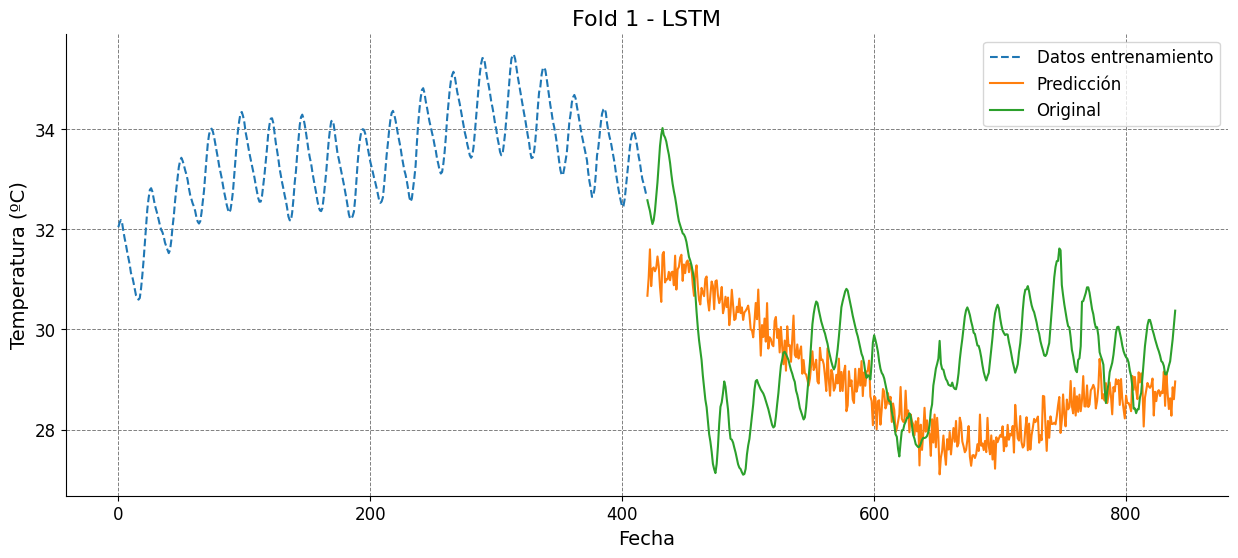

1/1 [==============================] - 0s 28ms/step - loss: 0.0147
Fold 2 - Test Loss: 0.014731117524206638
1/1 [==============================] - 0s 21ms/step
[[0.34472457 0.34616247 0.34384573 0.31608146 0.360977   0.368593
  0.34553534 0.35420063 0.353671   0.34781405 0.35206383 0.34935072
  0.34131336 0.37310234 0.3675974  0.36617947 0.33973363 0.35364512
  0.3436732  0.35064673 0.35186592 0.3352194  0.35866567 0.34851253
  0.35282534 0.36720282 0.35204518 0.35791594 0.36158666 0.33726957
  0.33892173 0.3512589  0.3437059  0.331435   0.33635223 0.330977
  0.3414635  0.31119165 0.3417289  0.32934907 0.30015758 0.3277349
  0.32077628 0.33955538 0.29792118 0.3188562  0.30614308 0.31632087
  0.31332424 0.27143908 0.30020714 0.2818825  0.3033734  0.29109362
  0.29305708 0.28694797 0.2927816  0.27631563 0.27487707 0.27891433
  0.24801917 0.24746284 0.2550135  0.25473124 0.26172128 0.26249737
  0.23790465 0.24309862 0.22677594 0.21576265 0.24779472 0.21185194
  0.2238876  0.21430825 0.225

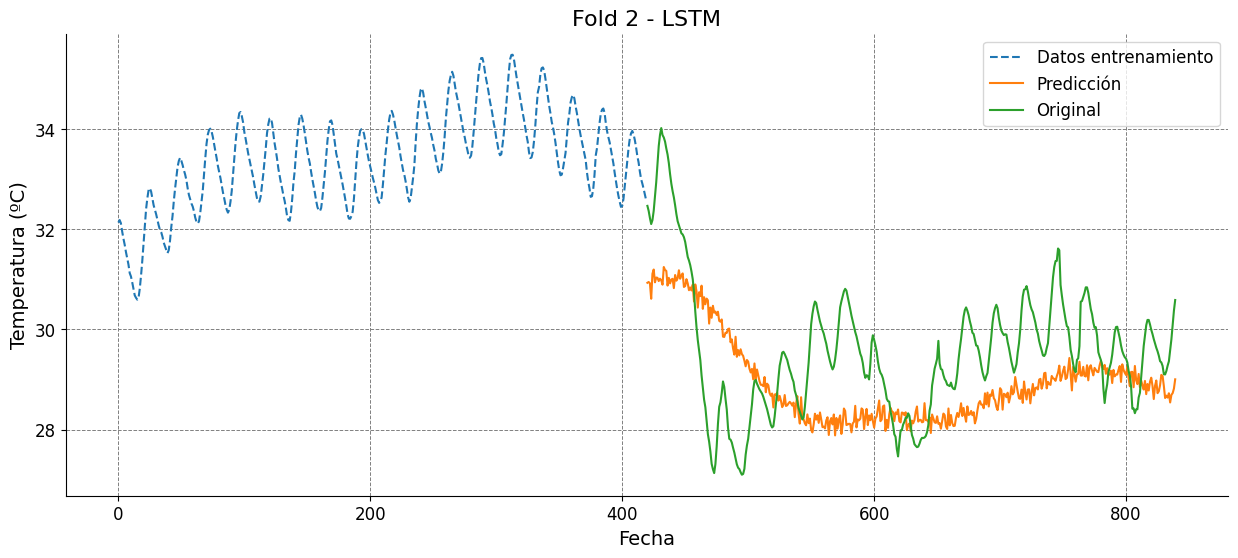

1/1 [==============================] - 0s 31ms/step - loss: 0.0113
Fold 3 - Test Loss: 0.011302879080176353
1/1 [==============================] - 0s 22ms/step
[[0.33660138 0.35145664 0.3668918  0.3583161  0.38025522 0.38887593
  0.35426474 0.3721665  0.4013537  0.37079465 0.36056352 0.34934625
  0.36681408 0.3834255  0.3874154  0.36326748 0.34039658 0.359898
  0.33948544 0.3321945  0.3683009  0.32787463 0.33000284 0.34495312
  0.33523524 0.34277683 0.34285858 0.37406528 0.33964303 0.34205973
  0.32722577 0.35773358 0.31442004 0.32325974 0.36249098 0.33576068
  0.3652937  0.32552674 0.30980068 0.32613328 0.3103504  0.2986164
  0.32625455 0.3187163  0.29963386 0.28256518 0.27910426 0.30327836
  0.27973363 0.25272852 0.26322383 0.26425698 0.29590863 0.27298957
  0.29085267 0.2593407  0.30448738 0.26662898 0.26546553 0.27206677
  0.24249816 0.2573456  0.2508636  0.25657526 0.22711542 0.26150987
  0.21157005 0.25359258 0.22530128 0.18403864 0.19275466 0.19139491
  0.22030298 0.20583266 0.2

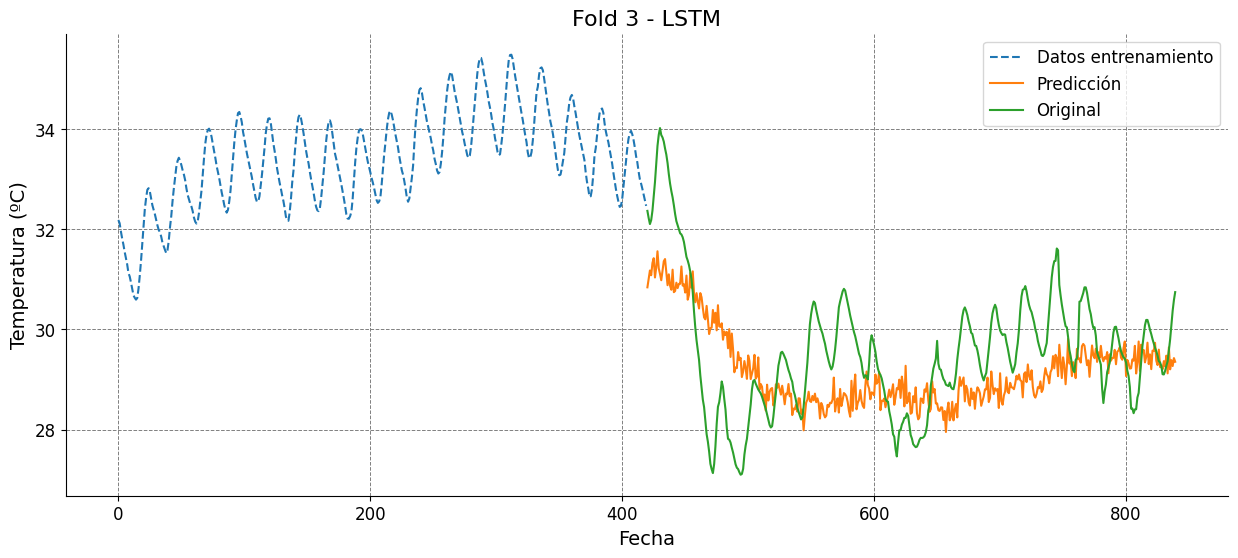

1/1 [==============================] - 0s 25ms/step - loss: 0.0137
Fold 4 - Test Loss: 0.013662385754287243
1/1 [==============================] - 0s 23ms/step
[[0.3205126  0.33273643 0.34561184 0.33893406 0.36470705 0.35078943
  0.33276248 0.3578474  0.3802793  0.35544556 0.35095477 0.3625023
  0.3511988  0.3421194  0.36920512 0.35648477 0.35162514 0.3589279
  0.3453358  0.3260032  0.33609158 0.32699925 0.31407136 0.33194286
  0.3120613  0.2973638  0.32930318 0.304522   0.31512925 0.3204943
  0.3060633  0.34665743 0.3199244  0.2976808  0.35332072 0.31529346
  0.32596076 0.32727343 0.29725826 0.2971461  0.2764443  0.27444422
  0.28283525 0.28021297 0.2555     0.25915575 0.23368701 0.27607292
  0.25897038 0.23374176 0.23742142 0.22667572 0.25718296 0.227524
  0.24001601 0.25976732 0.23610286 0.23914956 0.22869022 0.22067305
  0.20364326 0.21779948 0.20016372 0.21511354 0.18968783 0.22170994
  0.16880661 0.18775758 0.16591361 0.15912399 0.15417345 0.12751994
  0.15375583 0.15683892 0.160

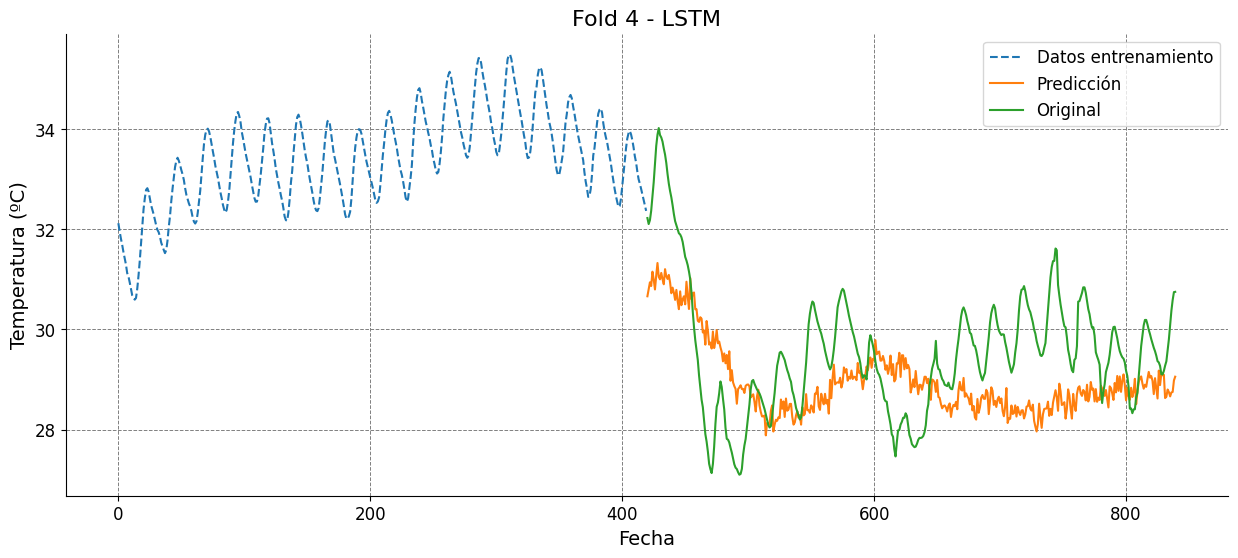

1/1 [==============================] - 0s 28ms/step - loss: 0.0082
Fold 5 - Test Loss: 0.008234423585236073
1/1 [==============================] - 0s 23ms/step
[[0.29937428 0.3235157  0.37359655 0.41130698 0.36740893 0.35356116
  0.3814673  0.39941046 0.41325825 0.4527657  0.40779474 0.39644656
  0.40013847 0.4137771  0.41471237 0.4187892  0.36293066 0.4039259
  0.36948964 0.365525   0.32251447 0.3750106  0.32729903 0.3184161
  0.3452357  0.3144157  0.36194444 0.3196263  0.34470952 0.31672466
  0.35209283 0.3943054  0.39313498 0.39813083 0.40705103 0.36365667
  0.3742077  0.34184176 0.3178139  0.3525523  0.3463832  0.32402998
  0.33912945 0.3141017  0.25341457 0.28977698 0.25852117 0.24382602
  0.2533407  0.2294507  0.25668827 0.25182083 0.25631467 0.24829075
  0.2611618  0.2890098  0.23196632 0.2483241  0.24844733 0.2681215
  0.25113282 0.26183867 0.23656827 0.24400625 0.2182871  0.23585498
  0.19868737 0.18703356 0.17857057 0.14589289 0.14151347 0.14068136
  0.11978471 0.13976574 0.1

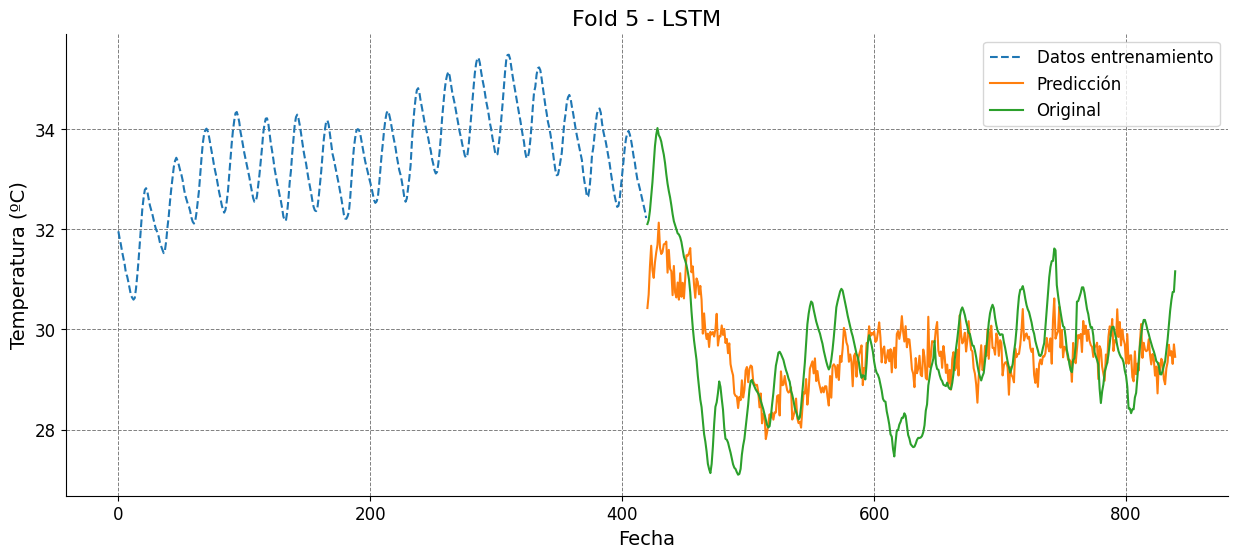

1/1 [==============================] - 0s 28ms/step - loss: 0.0050
Fold 6 - Test Loss: 0.004993973299860954
1/1 [==============================] - 0s 23ms/step
[[ 0.2994863   0.32514855  0.3437683   0.3560651   0.36657962  0.37645364
   0.37382036  0.41685048  0.4354477   0.4635892   0.44640702  0.41948026
   0.4429638   0.41868472  0.42179394  0.42884654  0.3580919   0.38415173
   0.331305    0.31265622  0.2766474   0.28869975  0.26838893  0.2657213
   0.29219103  0.25896975  0.29283258  0.30292654  0.31032652  0.31840295
   0.37137678  0.3913657   0.37709826  0.40792748  0.39147437  0.36898446
   0.3721125   0.34208342  0.31668237  0.3158263   0.28681624  0.2520333
   0.22537893  0.20254669  0.157718    0.15664276  0.12073694  0.1087569
   0.11247455  0.11399551  0.08992895  0.146842    0.1488595   0.15932205
   0.14342031  0.17122953  0.16047627  0.15651727  0.19135043  0.17538306
   0.16248241  0.13359348  0.12234613  0.1135546   0.07484564  0.07862313
   0.04050911  0.0123515   0.

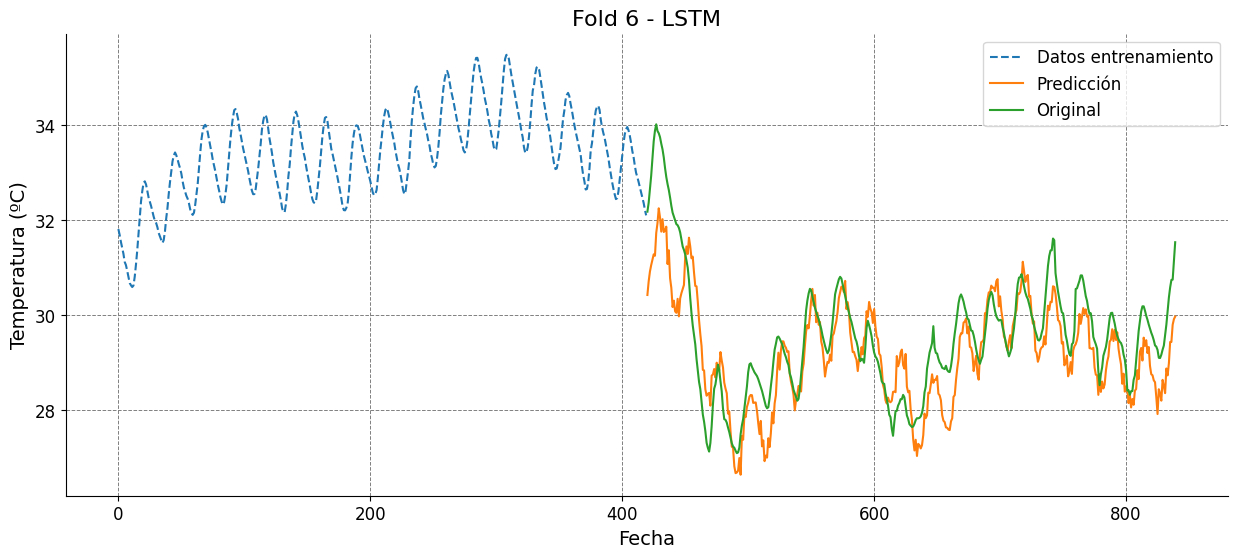

1/1 [==============================] - 0s 26ms/step - loss: 0.0067
Fold 7 - Test Loss: 0.0067374249920248985
1/1 [==============================] - 0s 26ms/step
[[ 0.3435564   0.3751147   0.37778947  0.3823486   0.40456766  0.4169288
   0.4268268   0.45759296  0.4551326   0.4820506   0.4671361   0.45859057
   0.46314514  0.45139     0.43328047  0.42014283  0.39707312  0.38685185
   0.35810167  0.369119    0.34025735  0.33996952  0.32829672  0.32364896
   0.34738705  0.35776913  0.354592    0.3912719   0.39796618  0.3979749
   0.40271226  0.40064836  0.42055744  0.42618665  0.42147154  0.4019353
   0.4054209   0.36548084  0.3421152   0.33417612  0.34020194  0.29431543
   0.2514729   0.25891584  0.2400065   0.1912889   0.1960607   0.17277482
   0.17660707  0.17139825  0.1735692   0.18625058  0.19255625  0.21161231
   0.2349936   0.20646138  0.23764662  0.21056004  0.22936529  0.21557033
   0.19857834  0.18519643  0.15079312  0.1491799   0.11738314  0.10362091
   0.09959913  0.07239851  0

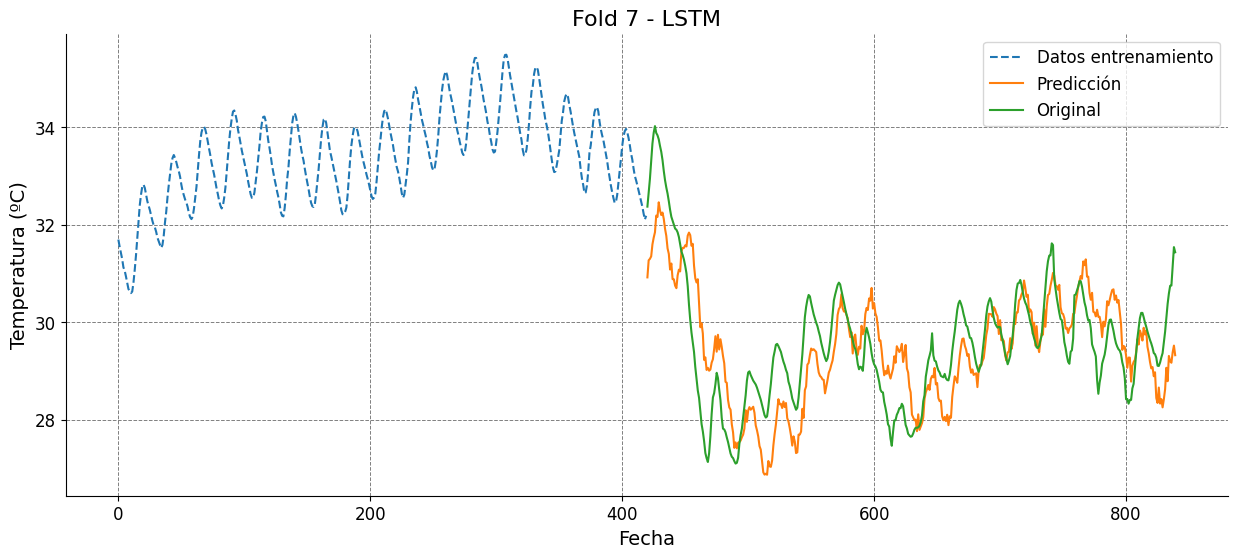

1/1 [==============================] - 0s 26ms/step - loss: 0.0090
Fold 8 - Test Loss: 0.00901133194565773
1/1 [==============================] - 0s 27ms/step
[[ 0.36244166  0.3768461   0.37957126  0.3924487   0.40638578  0.41709453
   0.4391392   0.44068518  0.44501668  0.4280545   0.44608408  0.4333542
   0.4190747   0.41767383  0.39777222  0.3846401   0.38357985  0.3684866
   0.36268145  0.36435318  0.36071154  0.35291547  0.35657728  0.36790043
   0.37657422  0.39613003  0.39287794  0.39990318  0.4118896   0.42987984
   0.41856942  0.42058587  0.42231452  0.41624337  0.40435797  0.4069655
   0.38761207  0.37273896  0.35514826  0.3221811   0.31085306  0.29918844
   0.2713767   0.28014743  0.27323347  0.2505908   0.252034    0.23776086
   0.2459482   0.25350967  0.25522426  0.25486007  0.2625963   0.26223758
   0.2791674   0.25695962  0.27738228  0.26309818  0.24358755  0.23686606
   0.21669738  0.19477218  0.18475567  0.16873723  0.15085837  0.12058054
   0.11445823  0.11177979  0.0

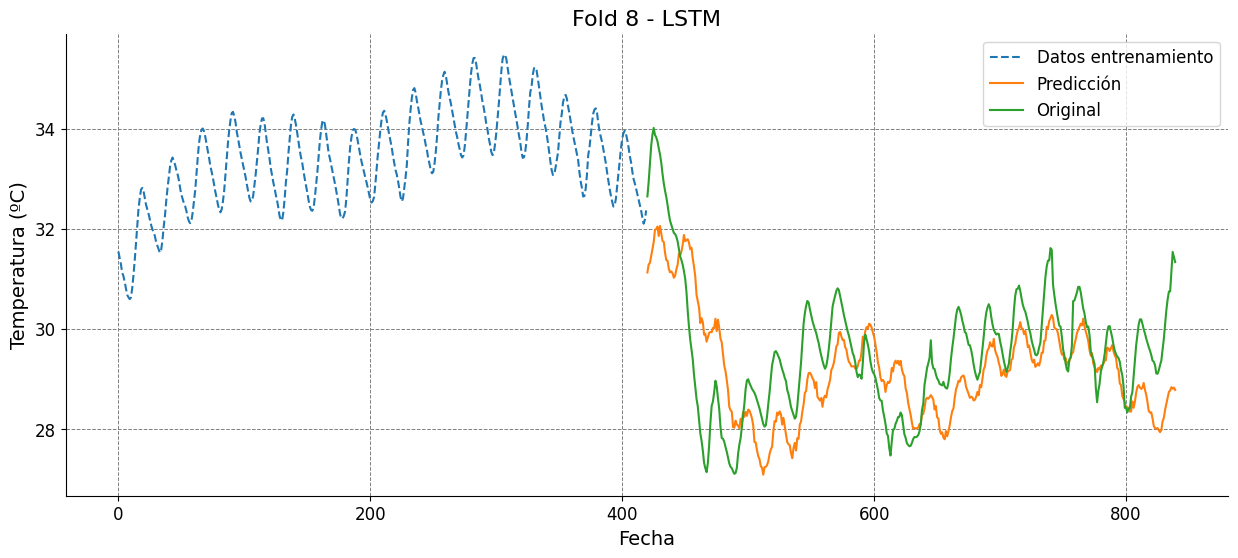

1/1 [==============================] - 0s 27ms/step - loss: 0.0042
Fold 9 - Test Loss: 0.004181625787168741
1/1 [==============================] - 0s 27ms/step
[[ 0.41129017  0.4397503   0.44283503  0.44144288  0.44951895  0.48953956
   0.46046695  0.47659034  0.45623568  0.46290755  0.45659417  0.41764012
   0.41685173  0.39251485  0.37312293  0.33412787  0.33707657  0.30885386
   0.31096232  0.31175208  0.3076306   0.3013059   0.31799656  0.31944725
   0.3351781   0.36211577  0.3381546   0.34417954  0.35700774  0.35578668
   0.3467162   0.3161737   0.3200539   0.2996069   0.2935066   0.2637016
   0.2523265   0.20873684  0.18703862  0.17238095  0.15140775  0.1351073
   0.09530741  0.0892112   0.10130356  0.09024686  0.07444479  0.07277583
   0.08024037  0.09371998  0.10440862  0.09518874  0.11335274  0.09925838
   0.14929451  0.10208525  0.11519826  0.0876881   0.07149448  0.07283064
   0.04715409  0.03464722  0.01074634 -0.00480655 -0.00450901 -0.0312289
  -0.01207183 -0.02855953 -0.

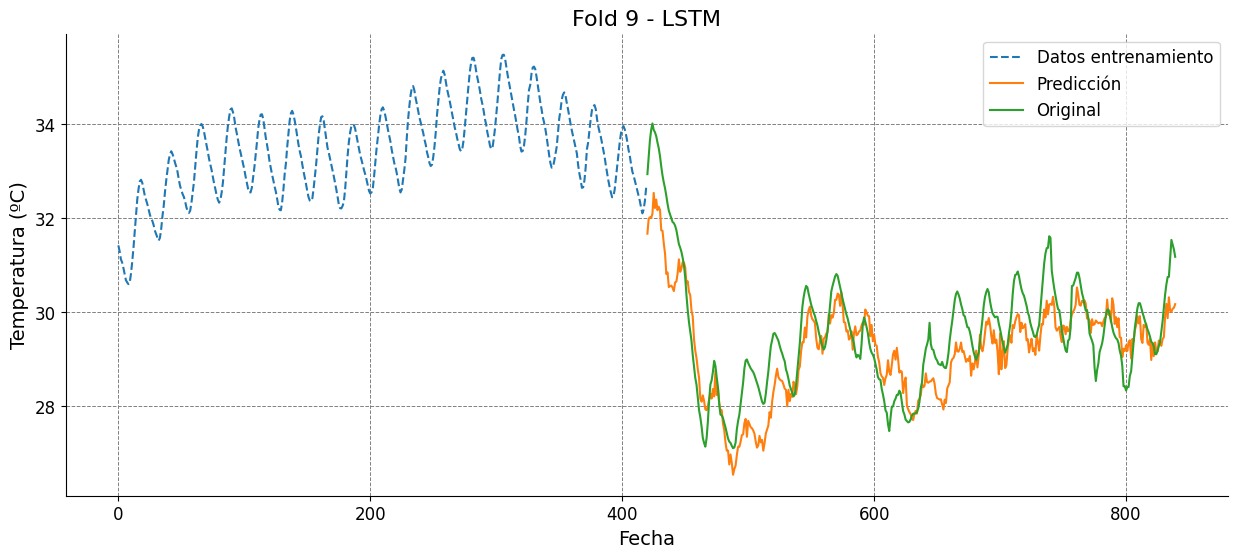

1/1 [==============================] - 0s 26ms/step - loss: 0.0028
Fold 10 - Test Loss: 0.0027953058015555143
1/1 [==============================] - 0s 26ms/step
[[ 4.47784126e-01  4.83157396e-01  4.85433191e-01  4.89595145e-01
   4.99259144e-01  5.26346385e-01  5.03674507e-01  5.13987839e-01
   4.92301166e-01  4.98374045e-01  4.84318435e-01  4.47020471e-01
   4.45253313e-01  4.21882927e-01  3.97679150e-01  3.67837399e-01
   3.59778702e-01  3.37817222e-01  3.34635764e-01  3.33965629e-01
   3.25784773e-01  3.27584267e-01  3.46104771e-01  3.47988456e-01
   3.65457058e-01  3.83727014e-01  3.68990600e-01  3.73674273e-01
   3.85344148e-01  3.71588200e-01  3.61596495e-01  3.36266607e-01
   3.33347559e-01  3.16008240e-01  3.01501423e-01  2.68914074e-01
   2.48307765e-01  2.03749567e-01  1.82280824e-01  1.65893197e-01
   1.36287898e-01  1.25475526e-01  9.19282138e-02  8.88243020e-02
   9.26915407e-02  8.59093815e-02  7.16381073e-02  8.02238584e-02
   8.65918919e-02  1.03293933e-01  1.15018956e

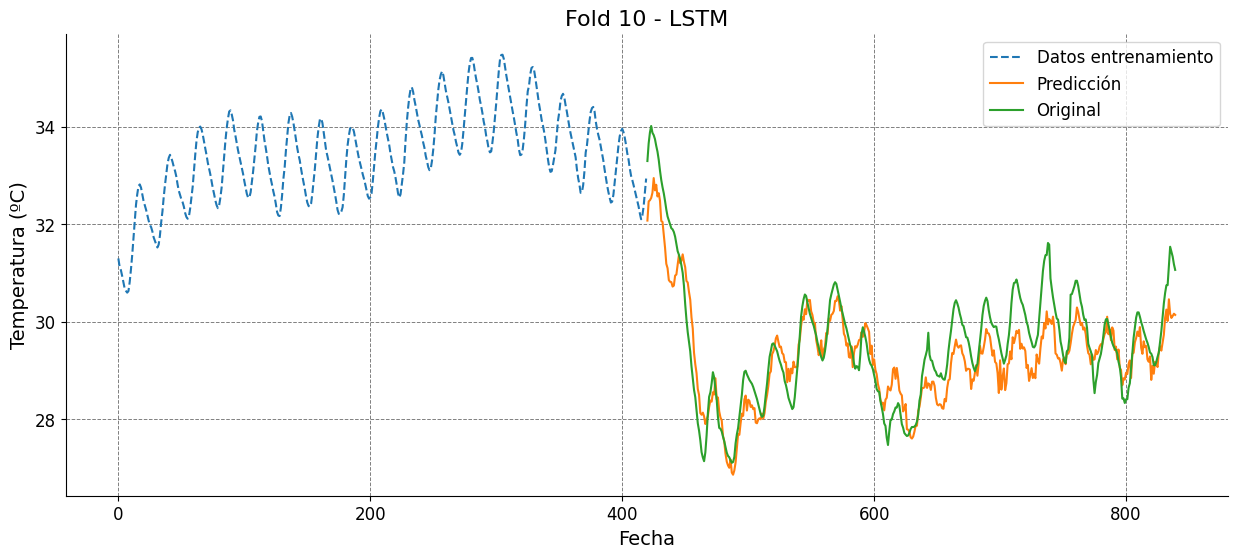

Average MSE: 1.1953089496128562
Average MAE: 0.8674993855975923
Average r2: 0.2893021921538602


In [11]:

# Define the callbacks
early_stopping = EarlyStopping(patience=50, monitor='val_loss', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)  # Example learning rate scheduler


# Define LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(64, activation='tanh', input_shape=(n_days, X.shape[2])))
model.add(keras.layers.Dense(n_days))
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # Clip gradients to prevent explosion
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.add(keras.layers.Dropout(0.2))


# Apply TimeSeriesSplit for cross-validation
mse_scores = []
mae_scores = []
r2_score = []
tscv = TimeSeriesSplit(n_splits=10, test_size=1)  # Assuming you want to split the data into 5 folds
for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train, epochs=500, batch_size=24, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler], verbose=0)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print(f"Fold {fold} - Test Loss: {loss}")

    # Make predictions
    predictions = model.predict(X_test)
    print(predictions)

    # Inverse transform the predictions and actual values
    inv_predictions = scalers['temperatura'].inverse_transform(predictions).flatten()
    inv_actual = scalers['temperatura'].inverse_transform(y_test).flatten()
    inv_input = scalers['temperatura'].inverse_transform(X_test[:, :, df.columns.get_loc('temperatura')].reshape(1, -1)).flatten()
    print(inv_predictions)
    # Calculate MSE
    mse = mean_squared_error(inv_actual, inv_predictions)
    mse_scores.append(mse)
    print(f"Fold {fold} - MSE: {mse}")

    # Calculate MAE
    mae = np.mean(np.abs(inv_actual - inv_predictions))
    mae_scores.append(mae)
    print(f"Fold {fold} - MAE: {mae}")

    #Caclular R2
    r2 = metrics.r2_score(inv_actual, inv_predictions)
    r2_score.append(r2)

    # Plot predictions, actual values, and input data
    plt.figure(figsize=(15, 7))
    plt.plot(np.arange(len(inv_input)), inv_input, label='Datos entrenamiento', linestyle='--')
    plt.plot(np.arange(len(inv_input), len(inv_input) + len(inv_actual)), inv_predictions, label='Predicción')
    plt.plot(np.arange(len(inv_input), len(inv_input) + len(inv_actual)), inv_actual, label='Original')

    # Configuración de los ejes y títulos
    plt.xlabel('Fecha', fontsize=14)
    plt.ylabel('Temperatura (ºC)', fontsize=14)
    plt.title(f'Fold {fold} - LSTM', fontsize=16)

    # Quitar los bordes superior y derecho
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Ajustar el tamaño de la leyenda
    plt.legend(fontsize=12)

    # Ajustar el tamaño de las etiquetas de los ejes
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Configurar la cuadrícula
    ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey')

    # Guardar el gráfico en una carpeta con buena resolución
    plt.savefig(f"fold_{fold}_LSTM.png", dpi=300, bbox_inches='tight')

    # Mostrar el gráfico
    plt.show()

# Calculate average MSE across all splits
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")
print(f"Average r2: {np.mean(r2_score)}")

In [36]:
start_date = "2023-08-09 00:00"
end_date = "2023-09-13 00:00"
date_range = pd.date_range(start=start_date, end=end_date, freq='H')

date_range

DatetimeIndex(['2023-08-09 00:00:00', '2023-08-09 01:00:00',
               '2023-08-09 02:00:00', '2023-08-09 03:00:00',
               '2023-08-09 04:00:00', '2023-08-09 05:00:00',
               '2023-08-09 06:00:00', '2023-08-09 07:00:00',
               '2023-08-09 08:00:00', '2023-08-09 09:00:00',
               ...
               '2023-09-12 15:00:00', '2023-09-12 16:00:00',
               '2023-09-12 17:00:00', '2023-09-12 18:00:00',
               '2023-09-12 19:00:00', '2023-09-12 20:00:00',
               '2023-09-12 21:00:00', '2023-09-12 22:00:00',
               '2023-09-12 23:00:00', '2023-09-13 00:00:00'],
              dtype='datetime64[ns]', length=841, freq='H')

In [34]:
len(date_range)

840

In [28]:
len(inv_input)

420

In [29]:
len(inv_predictions)

420

In [30]:
len(inv_input) + len(inv_actual)

840

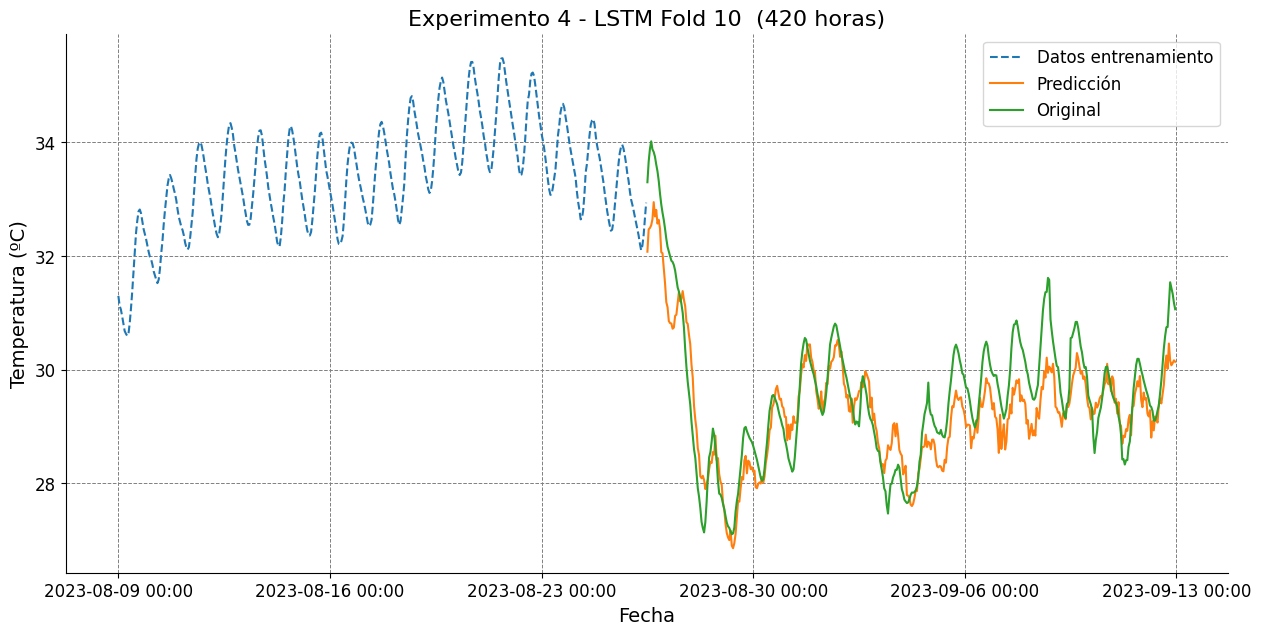

In [41]:
# Plot predictions, actual values, and input data
plt.figure(figsize=(15, 7))
plt.plot(np.arange(len(inv_input)), inv_input, label='Datos entrenamiento', linestyle='--')
plt.plot(np.arange(len(inv_input), len(inv_input) + len(inv_actual)), inv_predictions, label='Predicción')
plt.plot(np.arange(len(inv_input), len(inv_input) + len(inv_actual)), inv_actual, label='Original')

# Configuración de los ejes y títulos
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Temperatura (ºC)', fontsize=14)
plt.title(f'Experimento 4 - LSTM Fold {fold}  (420 horas)', fontsize=16)

# Quitar los bordes superior y derecho
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Ajustar el tamaño de la leyenda
plt.legend(fontsize=12)

# Ajustar el tamaño de las etiquetas de los ejes
ax.tick_params(axis='both', which='major', labelsize=12)

# Configurar la cuadrícula
ax.grid(True, which='both', linestyle='--', linewidth=0.7, color='grey')


ax.set_xticks(np.arange(len(date_range))[::168])  # Mostrar ticks cada 168 horas (una semana)
ax.set_xticklabels(date_range[::168].strftime('%Y-%m-%d %H:%M'))

# Guardar el gráfico en una carpeta con buena resolución
plt.savefig(f"fold_{fold}_LSTM.png", dpi=300, bbox_inches='tight')

# Mostrar el gráfico
plt.show()